In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('drive/My Drive/Colab Notebooks/dissertation/final')

Mounted at /content/drive


In [ ]:
%run 'import_final.ipynb'

In [ ]:
%run 'functions_final.ipynb'

In [ ]:
%run 'agents_final.ipynb'

In [ ]:
%run 'plotting_final.ipynb'

In [ ]:
%run 'simulations_final.ipynb'

In [ ]:
results_path = './numerical_results'
if not os.path.exists(results_path):
    os.makedirs(results_path)

# Generate Agent for Training

Here we generate all the parameters needed for our agent. Always do the setup here so that it forces us to create a file with all the parameters that can be rerun.

Make sure the fileheader is unique for the run. Setting the random seed is also important so that results are deterministic and repeatable. The current random state is saved and reloaded at the end of each run.

*** When generating the final agent file, run top to bottom so that random state is consistent

In [ ]:
# Header to output current run data
fileheader = '4Traders_0Fees_9995LW_0a'

# Set Random Seed
random_seed = 42
torch.manual_seed(random_seed)

# General parameters and setup
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Set Market Parameters

In [ ]:
###################################
# Parameters for reference market #
###################################

# These were all found in the spreadsheet
sigma = 1.   
mu =  0.     
# Time discretisation step length
tau = 60. / 60. / 24. / 365.25 
s_args = dict(sigma=sigma, tau=tau, mu=mu, increment_type="BM")

#######################
# Parameters for CPFM #
#######################

CPFM_kw_args = dict()

# TODO: Track down where I got these constants. I did find them somewhere
trade_size = 1.0
R_long = 0.2 
R_short = 0.2
# Always set this to 0. It makes more sense to control fees with the variable 
# liquidity fee since it has nearly the same impact on the agent
f_I = 0.0 
l_initial = 2.0 
l_search = 1.5  
l_release = 2.5 

random_agent_update = True # IMPORTANT
variable_fees = False # IMPORTANT

if not variable_fees:
    CPFM_kw_args['fee_liquidity'] = 0.0

if random_agent_update:
    num_traders = 4
    CPFM_kw_args['num_traders'] = num_traders
    CPFM_kw_args['traders_pay_fees'] = True

market_args = dict(trade_size=trade_size, R_long=R_long, R_short=R_short,
                    fee_infrastructure=f_I,
                    l_initial=l_initial, l_search=l_search,
                    l_release=l_release, 
                    random_agent_update=random_agent_update,
                    variable_fees=variable_fees,
                    CPFM_kw_args = CPFM_kw_args)

# Parameters For State Space Sampling

In [ ]:
###################################
#Parameters for the initial state #
###################################

sigma_x0 = 0.2 #0.1 # Reduced from 0.3
mu_x0 = np.log(1000000) # log of the inital pool value of A_S (spreadsheet)
initial_price = 3000 # spreadsheet
reference_variation = 0 # Starting variation between prices
reference_min = 0.
initial_inventory_variance = 0.

# These are actually deprecated and replaced by values in kw_Args 
ga_mean = 0.
ga_var = 0.
ma_var = 0.
x0_kwargs = dict()

# Set the initial margin amount so that sampler ensures that there is 
# always enough money in the starting general account
R = max(market_args['R_long'], market_args['R_short'])  
M_i = l_initial * R * trade_size

# Averge multiples of the min margin size to start with
x0_kwargs['mean_gen_int'] = 10
# Variation from the average min margin
x0_kwargs['var_gen_int'] = 2 
# Average minimum multiple of initial margin to start with
x0_kwargs['min_gen_int'] = 2 

if variable_fees:
  dims = 7 # number of dimensions
  #x0_kwargs['mean_fees'] = 0.02
  #x0_kwargs['var_fees'] = 0.01
  x0_kwargs['fee_range'] = 0.0 #0.05
else:
  dims = 6

x0_args = dict(sigma=sigma_x0, mu=mu_x0, initial_price=initial_price,
                reference_variation=reference_variation,
                reference_min=reference_min, T=initial_inventory_variance,
                ga_var=ga_var, ga_mean=ga_mean, ma_var=ma_var, 
                M_i=M_i, dim=dims,
                x0_kwargs=x0_kwargs)

simulation_sampler = partial(sample_x0, device=device, **x0_args) 

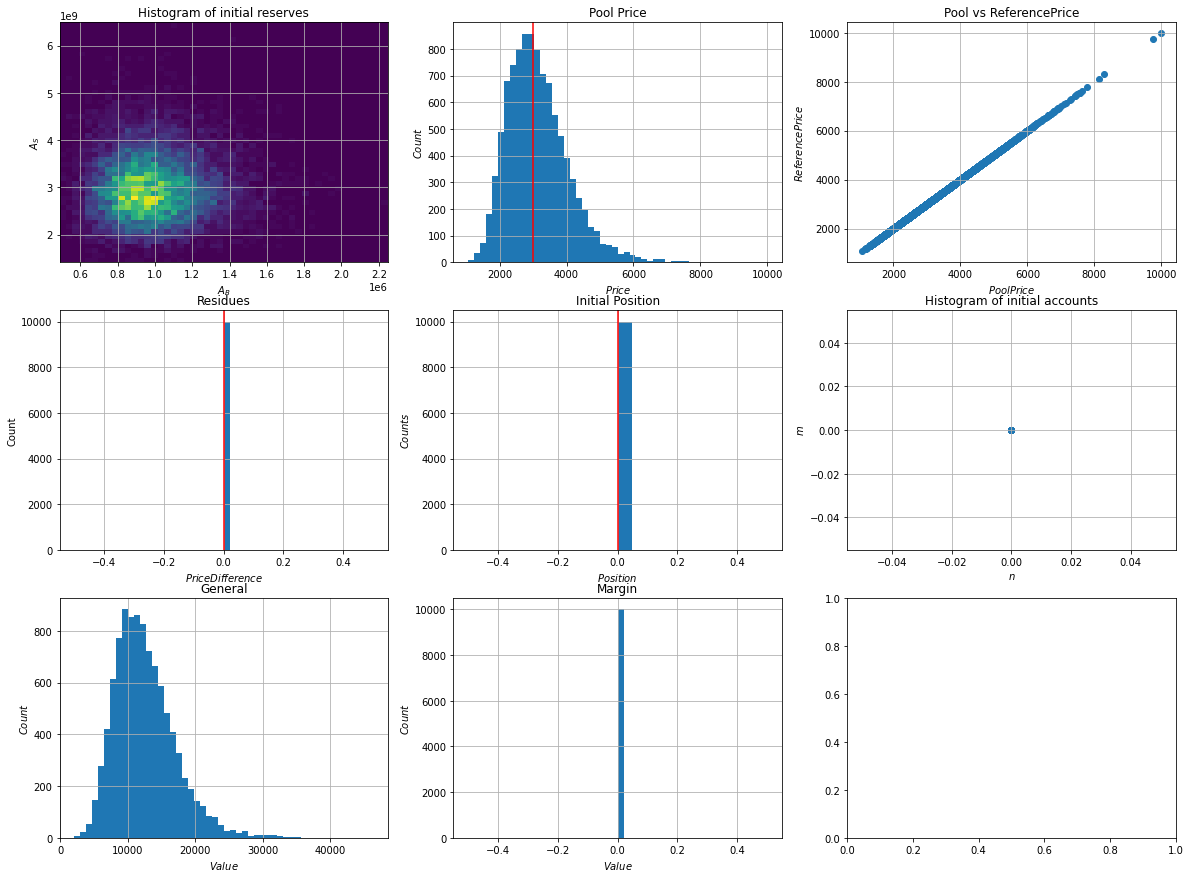

In [ ]:

save_fig = False
fig_name = fileheader + '_initial_state_sampler.png'

_ = plot_sampler(x0_args, 10000, save_fig=save_fig)

# Parameters for Neural Network

In [ ]:
#############################
# Parameters for Neural Net #
#############################

# learning hyperparameters

# I think I could maybe push as high as 75000 without crashing but worried 
# about GPU usage a bit
n_batch = 60000 
n_mc = 100
discount_factor = 0.95
lr = 0.005
scheduler = 'Exponential'
gamma = 0.9995 # 0.999 # Tuned this pretty well I think
# Not relevant with exponential scheduler
milestones = [1000] 

learning_args = dict(n_batch=n_batch, n_mc=n_mc, gamma=gamma, lr=lr, 
                      discount_factor=discount_factor, dims=dims,
                      milestones=milestones, scheduler=scheduler)


hidden_dims_C = [20, 20] 
activation_C = 'nn.Sigmoid'
output_activation_C = 'nn.Softmax'
normalize_input_C = True
normalize_hidden_C = True
normalize_output_C = False
initial_weight_var_C = 'Sigmoid'

C_args = dict(hidden_dims_C=hidden_dims_C,
              activation_C=activation_C,
              output_activation_C=output_activation_C, 
              normalize_input_C=normalize_input_C,
              normalize_hidden_C=normalize_hidden_C,
              normalize_output_C=normalize_output_C,
              initial_weight_var_C=initial_weight_var_C)

hidden_dims_v = [20, 20] 
activation_v = 'nn.ReLU'
output_activation_v = 'nn.Identity'
normalize_input_v = True
normalize_hidden_v = True
normalize_output_v = False
initial_weight_var_v = ''

v_args = dict(hidden_dims_v=hidden_dims_v,
              activation_v=activation_v,
              output_activation_v=output_activation_v,
              normalize_input_v=normalize_input_v,
              normalize_hidden_v=normalize_hidden_v,
              normalize_output_v=normalize_output_v,
              initial_weight_var_v=initial_weight_var_v)

# Utility Function Parameters

In [ ]:
######################
# Utility Parameters #
######################

inventory_penalty = 0.0

# I had slightly better performance with linear profit than linear wealth
# in some early tests. Thiw will mean that I need to scale down the inventory
# penalty a lot though
utility_args = dict(kind='Linear Wealth Inventory Penalty',
                    penalty_factor=inventory_penalty)
utility = partial(U, kwargs=utility_args)

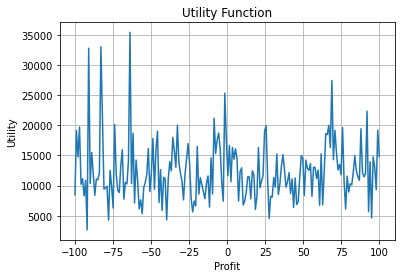

In [ ]:
profits = torch.linspace(-100, 100, 200, device = device)

plt.plot(profits.cpu().numpy(), utility(simulation_sampler(200),profits).cpu().numpy())
plt.xlabel('Profit')
plt.ylabel('Utility')
plt.title('Utility Function')
plt.grid()


save_fig = False
fig_name = fileheader + '_utility.png'
if save_fig:
  plt.savefig(os.path.join(results_path,fig_name))

plt.show()

# Generate the new type of sampler

In [ ]:
max_steps = 100 
random_agent_percentage = 1.0
ideal_agent_percentage = 0.0
if variable_fees:
  fee_range = 0.05 #x0_kwargs['fee_range']
else:
  fee_range = 0

sim_samp_args = dict(max_steps=max_steps,
                     random_agent_percentage=random_agent_percentage,
                     ideal_agent_percentage=ideal_agent_percentage,
                     fee_range=fee_range)

In [ ]:
sim_samp = SimulationSampler(utility=utility, market_args=market_args,
                             s_args=s_args, sampler=simulation_sampler,
                             **sim_samp_args)

modified_x0_sampler = partial(sim_samp.sample_x0)

In [ ]:
x0 = modified_x0_sampler(60000)

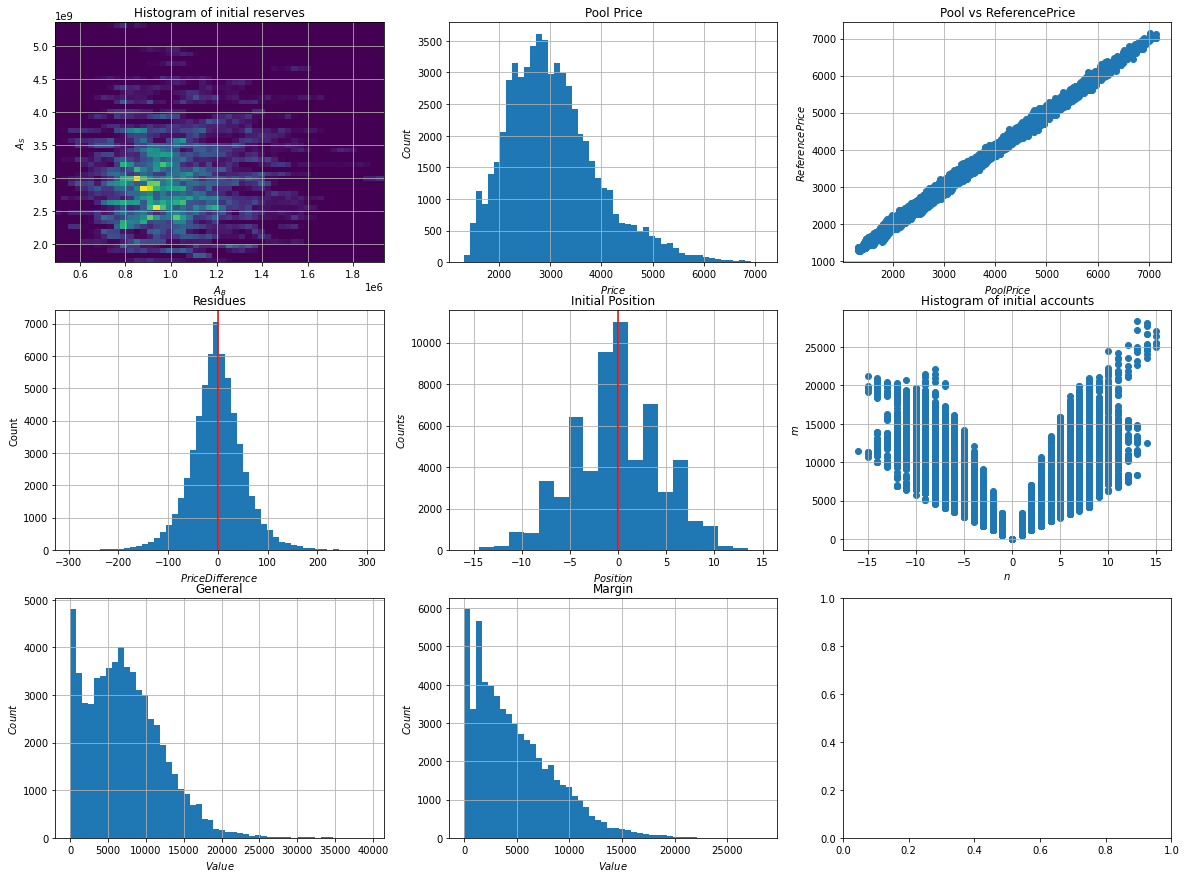

In [ ]:
plot_x0_dist(x0.numpy())

# Generate Agent and Parameters Files

In [ ]:
parameters= dict(market_args=market_args, s_args=s_args,
                 x0_args=x0_args, utility_args=utility_args,
                 learning_args=learning_args, C_args=C_args, 
                 v_args=v_args,random_seed=random_seed,
                 sim_samp_args=sim_samp_args)

training_history = []
parameters['training_history'] = training_history
bellman_loss = []
bellman_approx = []
utility = partial(U, kwargs=utility_args)
agent = ActorCritic(utility=utility, x0_sampler = modified_x0_sampler, device=device,
                    **learning_args, **C_args, **v_args, **market_args)
print('New agent')

New agent


In [ ]:
save_state(fileheader, agent, parameters, bellman_loss, bellman_approx,
           device=device, results_path=results_path)

tensor([0.9519])
